In [1]:
from depth_pipeline.depth_map import DepthRecovery
import cv2
import numpy as np

recoverer = DepthRecovery()
recoverer.initDepthAnything()

[DepthMap] Using device: cuda


### Get the images

In [2]:
img_pose_file = "/home/jason/ROS/bags/analysis/pose.txt"
img_pose = list()

f = open(img_pose_file, "r")
content = f.readlines()

frame1 = content[75].split(',')
frame2 = content[76].split(',')

frame1_pose = (float(frame1[1]), float(frame1[2]), float(frame1[3]))
frame1_img = frame1[0]

frame2_pose = (float(frame2[1]), float(frame2[2]), float(frame2[3]))
frame2_img = frame2[0]

img1 = cv2.imread("/home/jason/ROS/bags/images/wp_ground/"+frame1_img)
img2 = cv2.imread("/home/jason/ROS/bags/images/wp_ground/"+frame2_img)

In [3]:
recoverer.first = img1
recoverer.second = img2

In [4]:
# RealSense Intrinsics
k_input = [879.2263626388094, 879.3081232332211, 629.0191606917964, 350.9911507351595]

K = np.diag((k_input[0], k_input[1], 1))
K[0,2], K[1,2] = k_input[2], k_input[3]

In [5]:
recoverer.next(img2, K)
d1, d2 = recoverer.getRelativeDepth()
d1, d2 = d1.cpu().numpy(), d2.cpu().numpy()

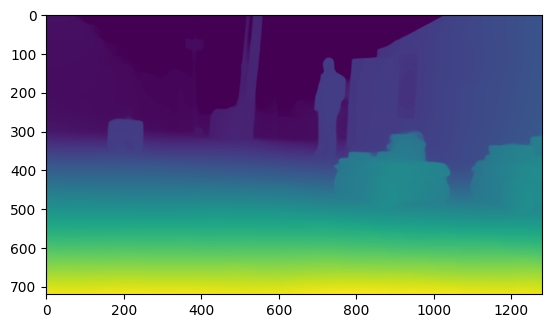

In [6]:
import matplotlib.pyplot as plt

plt.imshow(d1)

In [7]:
d1[400,900], d1[250,850], d1[25,800], d1[719,800]

(39.423916, 14.356607, 0.0, 82.72917)

In [8]:
minval = np.min(d1[np.nonzero(d1)])
maxval = np.max(d1)

print("min: ",np.min(d1[np.nonzero(d1)]), " at ", np.unravel_index(d1.argmin(), d1.shape))
print("max: ",np.max(d1), " at ", np.unravel_index(d1.argmax(), d1.shape))

min:  2.70901e-06  at  (0, 109)
max:  82.947105  at  (719, 756)


In [9]:
# normalize between [0,1] 
d1 = d1 / (maxval - minval)
#plt.imshow(d1)
print(d1[400,900], d1[250,850], d1[25,800], d1[719,756])

0.47528982 0.17308147 0.0 1.0


In [10]:
#ex = d1[450:,600]
#plt.plot(np.arange(270), ex)

In [11]:
def inverseDisparity(depth):
    range1 = np.minimum (depth.max() / (depth.min() + 0.001), 100.0)
    max1 = depth.max()
    min1 = max1 / range1

    d1 = 1 / np.maximum(depth, min1)
    d1 = (d1 - d1.min()) / (d1.max() - d1.min())
    #d1 = np.power(d1, 1.0/2.2) # optional gamma correction
    #d1 = d1 * 65535.0

    return d1#.astype("uint16")


In [12]:
#d = inverseDisparity(d1)
#plt.imshow(d)

In [13]:
#print(recoverer.p1_depth_)
max_d = np.max(recoverer.p1_depth_[:,-1])
min_d = np.min(recoverer.p1_depth_[:,-1])
min_w = np.unravel_index(recoverer.p1_depth_[:,-1].argmin(), recoverer.p1_depth_[:,-1].shape)
max_w = np.unravel_index(recoverer.p1_depth_[:,-1].argmax(), recoverer.p1_depth_[:,-1].shape)
print(max_d, recoverer.p1_depth_[max_w], "  ", min_d, recoverer.p1_depth_[min_w])

333.22043 [355.      185.      333.22043]    5.2420344 [660.        554.          5.2420344]


In [14]:
## MiDaS depth recovery
## if you know max and min absolute depth, which I take from SfM 

d1 = 1 - d1

A = (1 / min_d) - (1 / max_d)
B = 1 / max_d

td = 1 / (A * d1 + B)

In [15]:
print(td[400,900], td[250,850], td[25,800], td[719,756])

9.849982 6.318434 5.2420344 333.22043
